In [3]:
# def LatLonToXY (lat1, lon1, lat2=0, lon2=0): # lat1 and lon1 are the origins and all inputs are assumed to be in the right format of the lat lon
#     dx = (lon2-lon1)*40000*math.cos((lat1+lat2)*math.pi/360)/360 #经度约化的算法
#     dy = (lat1-lat2)*40000/360 #纬度
#     return dx, dy

def saveData(data, filename):
    #np.savez(filename,data = data)
    output = open(filename, 'wb')
    # Pickle dictionary using protocol 0.
    pickle.dump(data, output)
    output.close()

def loadData(filename):
    pkl_file = open(filename, 'rb')
    data = pickle.load(pkl_file)

    pkl_file.close()
    #loader = np.load(filename)
    return data

In [4]:
import os
import re
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.io as sio
import scipy.sparse as sp
from scipy.sparse import csc_matrix
import csv
import matplotlib.pyplot as plt
import datetime
import time
import utils
import clustering_worker
import os
import pickle
from math import radians, cos, sin, asin, sqrt, degrees, atan2, ceil

%matplotlib inline

In [5]:
trajectory=loadData('trajectory')

In [6]:
len(trajectory)

202504

In [7]:
trajectory[0]

array([[1477969147, 104.07513, 30.727240000000002],
       [1477969150, 104.07513, 30.72702],
       [1477969154, 104.07504, 30.72672],
       [1477969156, 104.07497, 30.7263],
       [1477969159, 104.07497, 30.725820000000002],
       [1477969162, 104.07496, 30.725440000000003],
       [1477969168, 104.07489, 30.724870000000003],
       [1477969171, 104.07476, 30.724559999999997],
       [1477969174, 104.07457, 30.72434],
       [1477969177, 104.07434, 30.724059999999998],
       [1477969180, 104.07422, 30.72379],
       [1477969183, 104.07424, 30.723509999999997],
       [1477969186, 104.07449, 30.72315],
       [1477969189, 104.07481, 30.723],
       [1477969193, 104.07506, 30.72298],
       [1477969195, 104.07539, 30.72301],
       [1477969198, 104.07576, 30.72308]], dtype=object)

In [8]:
len_traj = []
for traj in trajectory:
    len_traj.append(len(traj))
print(max(len_traj), min(len_traj))

1232 1


In [9]:
processed_trajectory = []
for traj in trajectory:
    if len(traj) > 10:
        processed_trajectory.append(traj)
len(processed_trajectory)
        

196046

In [10]:
len_traj = []
for traj in processed_trajectory:
    len_traj.append(len(traj))
print(max(len_traj), min(len_traj))

1232 11


(array([4.6604e+04, 4.4950e+04, 3.9722e+04, 2.8031e+04, 1.7061e+04,
        9.4710e+03, 4.9640e+03, 2.5750e+03, 1.2660e+03, 6.8500e+02,
        3.3800e+02, 1.8200e+02, 8.3000e+01, 5.1000e+01, 2.6000e+01,
        1.2000e+01, 1.0000e+01, 1.1000e+01, 2.0000e+00, 2.0000e+00]),
 array([  11.  ,   72.05,  133.1 ,  194.15,  255.2 ,  316.25,  377.3 ,
         438.35,  499.4 ,  560.45,  621.5 ,  682.55,  743.6 ,  804.65,
         865.7 ,  926.75,  987.8 , 1048.85, 1109.9 , 1170.95, 1232.  ]),
 <a list of 20 Patch objects>)

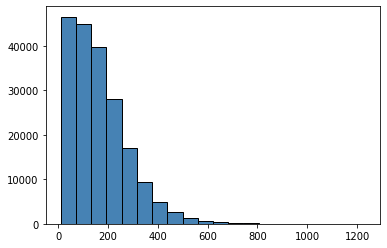

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
plt.hist(x = len_traj, # 指定绘图数据
          bins = 20, # 指定直方图中条块的个数
          color = 'steelblue', # 指定直方图的填充色
          edgecolor = 'black' # 指定直方图的边框色
          )

In [12]:
processed_trajectory[0]

array([[1477969147, 104.07513, 30.727240000000002],
       [1477969150, 104.07513, 30.72702],
       [1477969154, 104.07504, 30.72672],
       [1477969156, 104.07497, 30.7263],
       [1477969159, 104.07497, 30.725820000000002],
       [1477969162, 104.07496, 30.725440000000003],
       [1477969168, 104.07489, 30.724870000000003],
       [1477969171, 104.07476, 30.724559999999997],
       [1477969174, 104.07457, 30.72434],
       [1477969177, 104.07434, 30.724059999999998],
       [1477969180, 104.07422, 30.72379],
       [1477969183, 104.07424, 30.723509999999997],
       [1477969186, 104.07449, 30.72315],
       [1477969189, 104.07481, 30.723],
       [1477969193, 104.07506, 30.72298],
       [1477969195, 104.07539, 30.72301],
       [1477969198, 104.07576, 30.72308]], dtype=object)

In [13]:
def transform_len_angular(traj):
    tmp = [[0, 0] for _ in range(len(traj))]
    for i in range(len(traj)):
        if i == 0:
            tmp[i][0] = 0
            tmp[i][1] = 0
        else:
            radLatA = radians(traj[i][2])
            radLonA = radians(traj[i][1])
            radLatB = radians(traj[i - 1][2])
            radLonB = radians(traj[i - 1][1])
            
            dLon = radLonA - radLonB
            dLat = radLatA - radLatB
            a = sin(dLat / 2) ** 2 + cos(radLatB) *cos(radLatA) * sin(dLon / 2) ** 2
            c = 2 * asin(sqrt(a))
            d = c * 6371
#             print(i, dLat, dLon, radLatB, radLonB)
            tmp[i][0] = d
             
            y = sin(dLon) * cos(radLatB)
            x = cos(radLatA) * sin(radLatB) - sin(radLatA) * cos(radLatB) * cos(dLon)
            angular = degrees( atan2(y, x))
            angular = angular - tmp[i - 1][1]
            angular = (angular + 360) % 360
            if angular>180:
                angular = angular - 360
            tmp[i][1] = angular
    return tmp
transform_len_angular(processed_trajectory[1])

[[0, 0],
 [0.020300391016961804, 131.09402919778586],
 [0.016713843341961097, -4.313084466790087],
 [0.0254075427047427, 132.09827050193013],
 [0.005879450941092925, -151.07981072851905],
 [0.006940366735008632, 135.0854145118576],
 [0.00934666975284646, -152.95835230062522],
 [0.024886223770481074, 132.72764153955507],
 [0.015225450793393528, -151.02871251842015],
 [0.013132620167566916, 129.67947522285067],
 [0.01041055505677175, -145.67396399801507],
 [0.02039225813063932, 123.64224241021316],
 [0.025126635974613974, -136.84101698304897],
 [0.026755216513926146, 132.7421690131422],
 [0.02564623488039676, -137.01859094509373],
 [0.011758922696036851, 118.03676098336484],
 [0.011659495500421693, -62.94136044411039],
 [0.009229741234329434, 131.7536775844809],
 [0.02461265548413854, -62.94138772733544],
 [0.026404854420763176, 133.25366789548514],
 [0.017179973970298162, -62.13557047429299],
 [0.03384246986643743, 130.94788237021555],
 [0.029876340493077476, -62.79832309195672],
 [0.05

In [14]:
def transform_len_angular2(traj):
    tmp = [[0, 0] for _ in range(len(traj))]
    for i in range(len(traj)):
        if i == 0:
            tmp[i][0] = 0
            tmp[i][1] = 0
        else:
            radLatA = radians(traj[i][2])
            radLonA = radians(traj[i][1])
            radLatB = radians(traj[i - 1][2])
            radLonB = radians(traj[i - 1][1])
            
            dLon = radLonA - radLonB
            dLat = radLatA - radLatB
            a = sin(dLat / 2) ** 2 + cos(radLatB) *cos(radLatA) * sin(dLon / 2) ** 2
            c = 2 * asin(sqrt(a))
            d = c * 6371
#             print(i, dLat, dLon, radLatB, radLonB)
            tmp[i][0] = d
             
            y = sin(dLon) * cos(radLatB)
            x = dLat
            angular = degrees( atan2(y, x)) - tmp[i-1][1]
            angular = (angular + 360) % 360
            if angular>180:
                angular = angular - 360
            tmp[i][1] = angular
    return tmp
transform_len_angular2(processed_trajectory[1])

[[0, 0],
 [0.020300391016961804, 48.905947609434804],
 [0.016713843341961097, 4.313084740547538],
 [0.0254075427047427, 47.90169574721324],
 [0.005879450941092925, 151.07984501858095],
 [0.006940366735008632, 44.91455158584222],
 [0.00934666975284646, 152.95838692418204],
 [0.024886223770481074, 47.272326583550466],
 [0.015225450793393528, 151.02874565280968],
 [0.013132620167566916, 50.32049333466961],
 [0.01041055505677175, 145.673996021336],
 [0.02039225813063932, 56.35772843960717],
 [0.025126635974613974, 136.84104693201155],
 [0.026755216513926146, 47.25780106398781],
 [0.02564623488039676, 137.0186208964207],
 [0.011758922696036851, 61.9632101459747],
 [0.011659495500421693, 62.94137215295177],
 [0.009229741234329434, 48.24629073995766],
 [0.02461265548413854, 62.94136615432552],
 [0.026404854420763176, 46.746294856309476],
 [0.017179973970298162, 62.135568881132485],
 [0.03384246986643743, 49.05204600795298],
 [0.029876340493077476, 62.79833095786449],
 [0.05104879455821594, 61

In [15]:

transformed_trajectory = []
for traj in processed_trajectory:
    transformed_trajectory.append(transform_len_angular(traj))


In [16]:
transformed_trajectory[0]

[[0, 0],
 [0.024462883861625984, 0.0],
 [0.03444986190378562, -14.46056422889319],
 [0.04717873817137254, 6.3073370461978016],
 [0.053373564788937844, -6.3073370461978016],
 [0.04226488229937301, 5.011433890444835],
 [0.06373331062415942, -11.037716342809688],
 [0.036641815038816326, -8.786018570122565],
 [0.030467584303347686, -27.804549200944678],
 [0.03811436693952694, -7.422455358697448],
 [0.03213923901656658, -13.487459889816932],
 [0.03119321796286545, 17.0011738047653],
 [0.046620622480623555, 13.83491702443547],
 [0.03484019501943844, 47.56215165797397],
 [0.024000362400944702, 37.12107111285104],
 [0.031720073398617286, 58.915528994079864],
 [0.03621407306136856, 43.49604679468058]]

In [17]:
saveData(transformed_trajectory, 'transformed_trajectory')

In [18]:
transformed_traj=loadData('transformed_trajectory')

In [19]:
transformed_traj[0]

[[0, 0],
 [0.024462883861625984, 0.0],
 [0.03444986190378562, -14.46056422889319],
 [0.04717873817137254, 6.3073370461978016],
 [0.053373564788937844, -6.3073370461978016],
 [0.04226488229937301, 5.011433890444835],
 [0.06373331062415942, -11.037716342809688],
 [0.036641815038816326, -8.786018570122565],
 [0.030467584303347686, -27.804549200944678],
 [0.03811436693952694, -7.422455358697448],
 [0.03213923901656658, -13.487459889816932],
 [0.03119321796286545, 17.0011738047653],
 [0.046620622480623555, 13.83491702443547],
 [0.03484019501943844, 47.56215165797397],
 [0.024000362400944702, 37.12107111285104],
 [0.031720073398617286, 58.915528994079864],
 [0.03621407306136856, 43.49604679468058]]